In [1]:
!pip install wbdata
import wbdata
import pandas as pd 
from matplotlib import pyplot as plt
import numpy as np 
import cufflinks as cf
cf.go_offline()
import plotly.offline as py
import plotly.graph_objs as go
!pip install geopandas
import pandas
import geopandas
df = pandas.read_csv("https://raw.githubusercontent.com/danhammer/envirods/main/data/farmers-mkts.csv")
gdf = geopandas.GeoDataFrame(df,geometry=geopandas.points_from_xy(df.x, df.y))

  Using cached wbdata-0.3.0-py3-none-any.whl (14 kB)


/opt/conda/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning:

The Shapely GEOS version (3.10.3-CAPI-1.16.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.



In [2]:
SOURCE = 2 
indicators = wbdata.get_indicator(source=SOURCE)

In [3]:
indicators = {"NY.GDP.PCAP.CD":"GDP per capita",
              "NY.GDP.PCAP.KD.ZG": "GDP per capita growth",
              "SP.DYN.TFRT.IN":"Total Fertility Rate",
              "SP.POP.GROW":"Population Growth Rate",
              "SP.DYN.AMRT.MA":"Male Mortality",
              "SP.DYN.AMRT.FE":"Female Mortality",
              "SP.POP.1564.FE.ZS":"% Adult Female",
              "SP.POP.TOTL.FE.ZS":"% Female", 
              "SP.POP.TOTL" : "Total Population",
              "SM.POP.NETM" : "Net migration",
              "SP.URB.TOTL.IN.ZS": "Urban Population (% of total)"}

#### [Deliverable #A part 1] Population DataFrame Function
A function that returns a pandas DataFrame indexed by Region or Country and Year, with columns giving counts of people in different age-sex groups.

In [4]:
# Input: 
# location : 3 letter code 
def population_df(location = "USA"):
    labels = {"SP.POP." + "80UP" + ".MA": "Male:" + "80-UP","SP.POP." + "80UP" + ".FE": "Female:" + "80-UP"}
    labels.update({"SP.POP." + f"{i:02d}" + f"{i+4:02d}" + ".MA": "Male:" + f"{i:02d}" + "-" + f"{i+4:02d}" for i in range(0, 80, 5)})
    labels.update({"SP.POP." + f"{i:02d}" + f"{i+4:02d}" + ".FE": "Female:" + f"{i:02d}" + "-" + f"{i+4:02d}" for i in range(0, 80, 5)})
    df = wbdata.get_dataframe(labels, country = location) 
    df.reset_index(inplace = True)
    df["Region"] = location
    df["date"] = df["date"].astype(int)
    df.set_index(["Region", "date"], inplace = True)
    return df
population_df("USA").head()

Male:80-UP  Female:80-UP  Male:00-04  Male:05-09  Male:10-14  \
Region date                                                                 
USA    2021   5141691.0     7481166.0   9649499.0  10350050.0  10981126.0   
       2020   5034000.0     7322597.0   9852037.0  10415215.0  11134524.0   
       2019   4920646.0     7191218.0   9966405.0  10406055.0  11106026.0   
       2018   4867015.0     7157291.0  10075446.0  10491691.0  11057812.0   
       2017   4828475.0     7142701.0  10132520.0  10609795.0  10951980.0   

             Male:15-19  Male:20-24  Male:25-29  Male:30-34  Male:35-39  ...  \
Region date                                                              ...   
USA    2021  11093229.0  11051728.0  11457880.0  11655269.0  11205436.0  ...   
       2020  11074742.0  11019123.0  11624147.0  11558689.0  11181191.0  ...   
       2019  10987004.0  10951050.0  11663144.0  11361102.0  11050733.0  ...   
       2018  10944241.0  11028203.0  11698726.0  11234670.0  10938202.0  ...   
       2017  10901962.0  11158423.0  11634024.0  11123129.0  10770172.0  ...   

             Female:30-34  Female:35-39  Female:40-44  Female:45-49  \
Region date                                                           
USA    2021    11405195.0    10966698.0    10556704.0    10045368.0   
       2020    11286312.0    10952602.0    10376717.0    10278884.0   
       2019    11071806.0    10846744.0    10142512.0    10427530.0   
       2018    10938677.0    10770283.0    10022352.0    10574380.0   
       2017    10837966.0    10643766.0     9971595.0    10659578.0   

             Female:50-54  Female:55-59  Female:60-64  Female:65-69  \
Region date                                                           
USA    2021    10556848.0    10931308.0    10784355.0     9670021.0   
       2020    10547806.0    11141839.0    10723886.0     9509351.0   
       2019    10548318.0    11163030.0    10564689.0     9015729.0   
       2018    10725051.0    11184265.0    10435807.0     8691035.0   
       2017    10929543.0    11189734.0    10241524.0     8574778.0   

             Female:70-74  Female:75-79  
Region date                              
USA    2021     7725296.0     5438472.0  
       2020     7454420.0     5166090.0  
       2019     7227138.0     4994841.0  
       2018     6996163.0     4809893.0  
       2017     6638861.0     4613896.0  

[5 rows x 34 columns]

#### [Deliverable #A part 2] Population Question Function
A python function named population that will deliver information to answer the queries of the following form: In [year] how many [people/males/females] aged [low] to [high] were living in [the world/region/country]?

In [5]:
# Inputs:
# location: 3 country letter code
# year: integer
# sex: "Male", "Female", "Total"
# age_range: list of strings, ["low","high"], must take in age ranges as those given in the data 
#["00","04"],["05","09"],["10","14"], ... ,["80","UP"]

def population(location, year, sex, age_range):
    lower_age, upper_age = age_range[0], age_range[1]
    if sex != "Total":
        sex_age = sex+ ":"+ lower_age + "-" + upper_age
        return population_df(location).droplevel("Region").loc[year, sex_age]
    else:
        fe = "Female"+ ":"+ lower_age + "-" + upper_age
        ma = "Male"+ ":"+ lower_age + "-" + upper_age
        tot = population_df(location).droplevel("Region").loc[year, fe] + population_df(location).droplevel("Region").loc[year, ma]
        return tot
    
population('USA', 2020, "Total", ["00","04"])

19269549.0

#### [Deliverable #B] Population Pyramids


In [6]:
age_ranges = []


py.init_notebook_mode(connected=True)

layout = go.Layout(barmode='overlay',
                   yaxis=go.layout.YAxis(range=[0, 90], title='Age'),
                   xaxis=go.layout.XAxis(title='Number'))

for i in range(0,80,5):
    age_ranges.append(f"{i:02d}"+f"{i+4:02d}")

age_ranges.append("80UP")

male_variables = {"SP.POP."+age_range+".MA":"Males "+age_range for age_range in age_ranges}
female_variables = {"SP.POP."+age_range+".FE":"Females "+age_range for age_range in age_ranges}

variables = male_variables
variables.update(female_variables)

def fun(country):
    df = wbdata.get_dataframe(variables,country=country)
    #print(df.query("date=='2020'").sum(axis=0))
    years = range(2020,1960,-20)

    # This makes a list of graphs, year by year
    bins = [go.Bar(x = df.loc[str(year),:].filter(regex="Male").values,
                   y = [int(s[:2])+1 for s in age_ranges],
                   orientation='h',
                   name='Men {:d}'.format(year),
                   hoverinfo='skip'
                  )
            for year in years]
          
    bins += [go.Bar(x = -df.loc[str(year),:].filter(regex="Female").values,
                    y=[int(s[:2])+1 for s in age_ranges],
                    orientation='h',
                    name='Women {:d}'.format(year),
                    hoverinfo='skip',
               )
             for year in years]
    return py.iplot(dict(data=bins, layout=layout))
fun("USA"), fun("JPN"), fun("IND")

(None, None, None)

#### [Deliverable #B]  Data Analysis Functions and Plots 

Growth Rate Function: Takes in initial year, final year, country, indicator and year step size (eg: 20 years) 
and outputs a list of growth rates of the indicator for the year increments  

Average Function: Takes in initial year, final year, country, indicator and year step size (eg: 20 years) and outputs a list of averages over the step sizes. 

In [7]:
def growth_rate(initial, final, country, indicator, step):
    df = wbdata.get_dataframe(indicators, country=country)
    df.index = df.index.astype("int")
    start_years = np.arange(initial, final, step)
    end_years = np.arange(initial + step - 1, final + step, step)
    init_data = [df.loc[i, indicator] for i in start_years]
    fin_data = [df.loc[e, indicator] for e in end_years]
    pair = [(init_data[i], fin_data[i]) for i in range(0, len(init_data))]
    return [(((x[1] - x[0])/x[0]) * 100) for  x in pair ]

def average(initial, final, country, indicator, step):
    df = wbdata.get_dataframe(indicators, country=country)
    df.index = df.index.astype("int")
    start_years = np.arange(initial, final, step)
    end_years = np.arange(initial + step - 1, final + step, step)
    pair = [(start_years[i], end_years[i]) for i in range(0, len(start_years))]
    lts = [[df.loc[x[1]:x[0], indicator]] for x in pair]
    return [np.average(i) for i in lts]

#### Analysis Dataframe: 
A DataFrame with growth rates and average rates over 20 year periods from 1960-2020 for USA, India and Japan. The indicators include:
1. GDP per capita growth
2. Population Growth
3. Average Fertility Rate
4. Urban Population growth

In [8]:
#Create new dataframe called Analysis with GDP growth, Population Growth, Average Total Fertility Rate
#Add data from US: 
data = growth_rate(1961, 2020, "USA", "GDP per capita", 20)
index = ["1961-1980","1981 - 2000", "2001 - 2020"]
analysis = pd.DataFrame(data, index, columns = ["US GDP per capita growth (%)"])
analysis["US Population growth (%)"] = growth_rate(1961, 2020, "USA", "Total Population", 20)
analysis["US Average Fertility Rate"] = average(1961, 2020, "USA", "Total Fertility Rate", 20)
analysis["US Urban Population Growth Rate (%)"] = growth_rate(1961,2020, "USA", "Urban Population (% of total)", 20)

In [9]:
# Add data from Japan to the Analysis dataframe 
analysis["Japan GDP per capita growth (%)"] = growth_rate(1961, 2020, "JPN", "GDP per capita", 20)
analysis["Japan Population growth (%)"] = growth_rate(1961, 2020, "JPN", "Total Population", 20)
analysis["Japan Average Fertility Rate"] = average(1961, 2020, "JPN", "Total Fertility Rate", 20)
analysis["Japan Urban Population Growth Rate (%)"] = growth_rate(1961,2020, "JPN", "Urban Population (% of total)", 20)

In [10]:
# Add data from India to the Analysis dataframe
analysis["India GDP per capita growth (%)"] = growth_rate(1961, 2020, "IND", "GDP per capita", 20)
analysis["India Population growth (%)"] = growth_rate(1961, 2020, "IND", "Total Population", 20)
analysis["India Average Fertility Rate"] = average(1961, 2020, "IND", "Total Fertility Rate", 20)
analysis["India Urban Population Growth Rate (%)"] = growth_rate(1961,2020, "IND", "Urban Population (% of total)", 20)

In [11]:
analysis

,US GDP per capita growth (%),US Population growth (%),US Average Fertility Rate,US Urban Population Growth Rate (%),Japan GDP per capita growth (%),Japan Population growth (%),Japan Average Fertility Rate,Japan Urban Population Growth Rate (%),India GDP per capita growth (%),India Population growth (%),India Average Fertility Rate,India Urban Population Growth Rate (%)
1961-1980,310.061428,23.699582,2.394075,4.775708,1563.425042,24.190102,1.98115,18.628627,211.028846,52.695414,5.5065,28.094499
1981 - 2000,159.943347,22.964801,1.947225,6.992827,278.076116,7.803775,1.56850,3.115126,62.857010,48.643472,4.0112,18.149208
2001 - 2020,71.086547,16.328840,1.921875,4.328950,16.020333,-0.698393,1.36850,14.741843,324.621968,29.418422,2.6050,25.102085


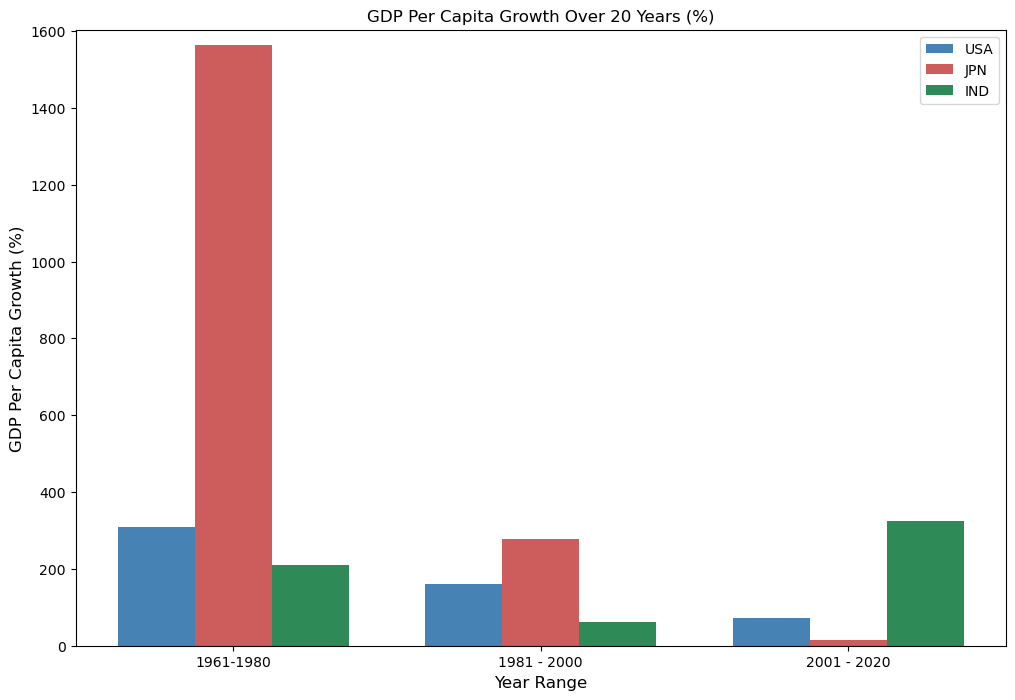

In [12]:
# Create a plot of the GDP growth over the 20 year periods for each country, US, Japan and India  

barWidth = 0.25
fig = plt.subplots(figsize =(12, 8))

# set height of bar
USA = analysis.loc[:,"US GDP per capita growth (%)"]
JPN = analysis.loc[:,"Japan GDP per capita growth (%)"]
IND = analysis.loc[:,"India GDP per capita growth (%)"]
 
# Set position of bar on X axis
br1 = np.arange(len(USA))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
 
# Make the plot
plt.bar(br1, USA, color ="steelblue", width = barWidth, label ='USA')
plt.bar(br2, JPN, color ="indianred", width = barWidth,
         label ='JPN')
plt.bar(br3, IND, color ='seagreen', width = barWidth, label ='IND')
 
# Adding Xticks
plt.xlabel('Year Range', fontsize = 12)
plt.ylabel('GDP Per Capita Growth (%)', fontsize = 12)
plt.title("GDP Per Capita Growth Over 20 Years (%)")
plt.xticks([r + barWidth for r in range(len(USA))],
        analysis.index )
max_y_lim = max(JPN) + 40
min_y_lim = 0
plt.ylim(min_y_lim, max_y_lim)
 
plt.legend()

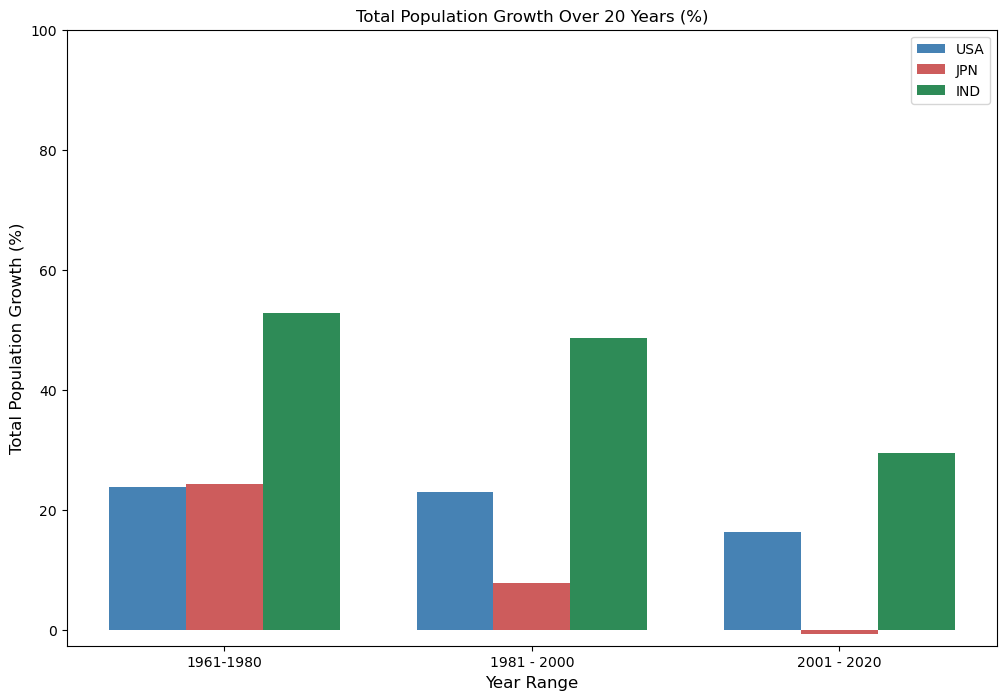

In [13]:
# Create a plot of the Population growth over the 20 year periods for each country, US, Japan and India  

barWidth = 0.25
fig = plt.subplots(figsize =(12, 8))

 
# set height of bar
USA = analysis.loc[:,"US Population growth (%)"]
JPN = analysis.loc[:,"Japan Population growth (%)"]
IND = analysis.loc[:,"India Population growth (%)"]
 
# Set position of bar on X axis
br1 = np.arange(len(USA))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
 
# Make the plot
plt.bar(br1, USA, color ="steelblue", width = barWidth, label ='USA')
plt.bar(br2, JPN, color ="indianred", width = barWidth,
         label ='JPN')
plt.bar(br3, IND, color ='seagreen', width = barWidth, label ='IND')
 
# Adding Xticks
plt.xlabel('Year Range', fontsize = 12)
plt.title("Total Population Growth Over 20 Years (%)")
plt.ylabel('Total Population Growth (%)', fontsize = 12)
plt.xticks([r + barWidth for r in range(len(USA))],
        analysis.index )
max_y_lim = 100
min_y_lim = min(JPN) -2
plt.ylim(min_y_lim, max_y_lim)
 
plt.legend()
plt.show()

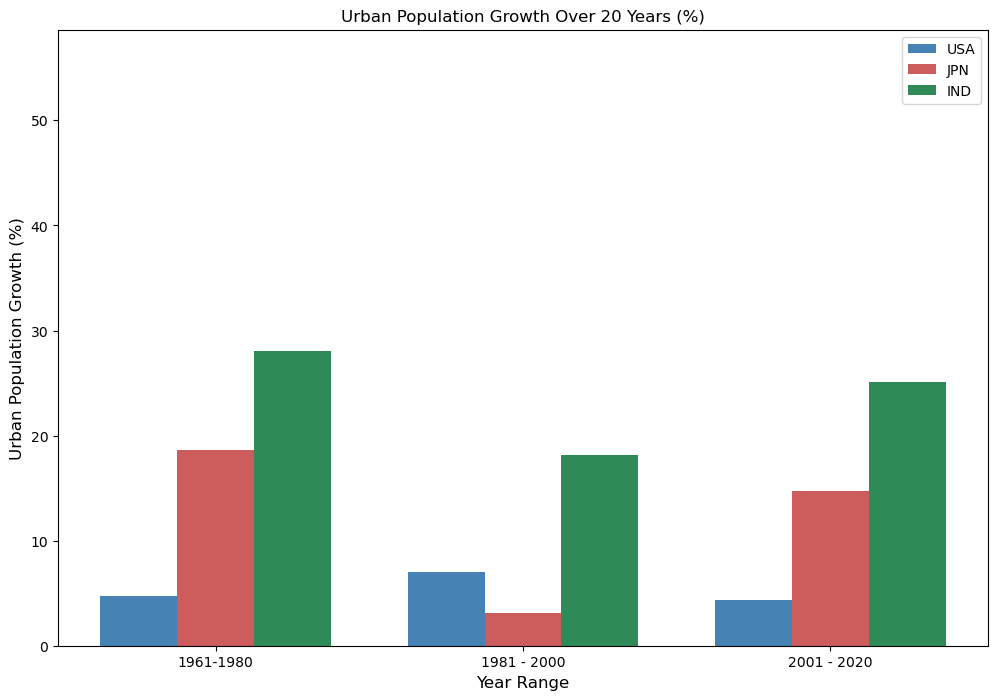

In [14]:
# Create a plot of the Urban Population growth over the 20 year periods for each country, US, Japan and India  

barWidth = 0.25
fig = plt.subplots(figsize =(12, 8))

 
# set height of bar
USA = analysis.loc[:,"US Urban Population Growth Rate (%)"]
JPN = analysis.loc[:,"Japan Urban Population Growth Rate (%)"]
IND = analysis.loc[:,"India Urban Population Growth Rate (%)"]
 
# Set position of bar on X axis
br1 = np.arange(len(USA))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
 
# Make the plot
plt.bar(br1, USA, color ="steelblue", width = barWidth, label ='USA')
plt.bar(br2, JPN, color ="indianred", width = barWidth,
         label ='JPN')
plt.bar(br3, IND, color ='seagreen', width = barWidth, label ='IND')
 
# Adding Xticks
plt.xlabel('Year Range', fontsize = 12)
plt.title("Urban Population Growth Over 20 Years (%)")
plt.ylabel('Urban Population Growth (%)', fontsize = 12)
plt.xticks([r + barWidth for r in range(len(USA))],
        analysis.index )
max_y_lim = max(JPN) + 40
min_y_lim = 0
plt.ylim(min_y_lim, max_y_lim)
 
plt.legend()
plt.show()

In [15]:
us = wbdata.get_dataframe(indicators, country="USA")
us.index = us.index.astype("int")

jpn = wbdata.get_dataframe(indicators, country="JPN")
jpn.index = jpn.index.astype("int")

ind = wbdata.get_dataframe(indicators, country="IND")
ind.index = ind.index.astype("int")

Text(0.5, 1.0, 'GDP Growth vs Average Fertility Rate over 20 Years')

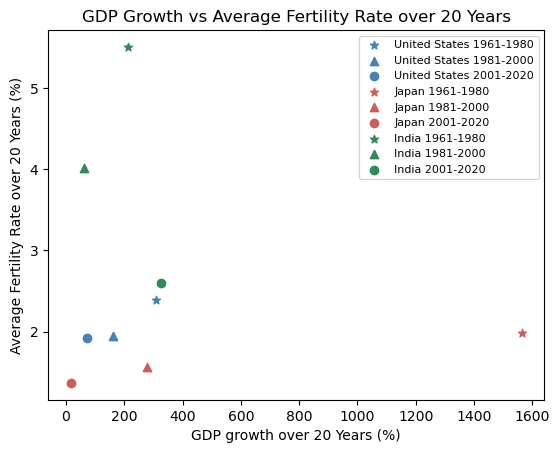

In [16]:
# Scatter Plot of GDP Growth vs Average Fertility Rate 
# ["lightblue", "steelblue", "darkblue"]


us_plt_1 = plt.scatter(x = analysis.loc[:, "US GDP per capita growth (%)"][0], y = analysis.loc[:, "US Average Fertility Rate" ][0], c= "steelblue", marker = "*")
us_plt_2 = plt.scatter(x = analysis.loc[:, "US GDP per capita growth (%)"][1], y = analysis.loc[:, "US Average Fertility Rate" ][1], c= "steelblue", marker = "^")
us_plt_3 = plt.scatter(x = analysis.loc[:, "US GDP per capita growth (%)"][2], y = analysis.loc[:, "US Average Fertility Rate" ][2], c= "steelblue", marker = "o")

jpn_plt_1 = plt.scatter(x = analysis.loc[:, "Japan GDP per capita growth (%)"][0], y = analysis.loc[:, "Japan Average Fertility Rate" ][0], c= "indianred", marker = "*")
jpn_plt_2 = plt.scatter(x = analysis.loc[:, "Japan GDP per capita growth (%)"][1], y = analysis.loc[:, "Japan Average Fertility Rate" ][1], c= "indianred", marker = "^")
jpn_plt_3 = plt.scatter(x = analysis.loc[:, "Japan GDP per capita growth (%)"][2], y = analysis.loc[:, "Japan Average Fertility Rate" ][2], c= "indianred", marker = "o")

ind_plt_1 = plt.scatter(x = analysis.loc[:, "India GDP per capita growth (%)"][0], y = analysis.loc[:, "India Average Fertility Rate" ][0], c= "seagreen", marker = "*")
ind_plt_2 = plt.scatter(x = analysis.loc[:, "India GDP per capita growth (%)"][1], y = analysis.loc[:, "India Average Fertility Rate" ][1], c= "seagreen", marker = "^")
ind_plt_3 = plt.scatter(x = analysis.loc[:, "India GDP per capita growth (%)"][2], y = analysis.loc[:, "India Average Fertility Rate" ][2], c= "seagreen", marker = "o")

plt.legend((us_plt_1, us_plt_2, us_plt_3, jpn_plt_1, jpn_plt_2, jpn_plt_3, ind_plt_1, ind_plt_2, ind_plt_3),
           ('United States 1961-1980','United States 1981-2000', 'United States 2001-2020','Japan 1961-1980','Japan 1981-2000', 'Japan 2001-2020','India 1961-1980','India 1981-2000', 'India 2001-2020'),
           scatterpoints=1,
           loc='upper right',
           fontsize=8)
plt.xlabel("GDP growth over 20 Years (%)")
plt.ylabel("Average Fertility Rate over 20 Years (%)")
plt.title("GDP Growth vs Average Fertility Rate over 20 Years")

Text(0, 0.5, 'Male Mortality, Deaths per 10,000')

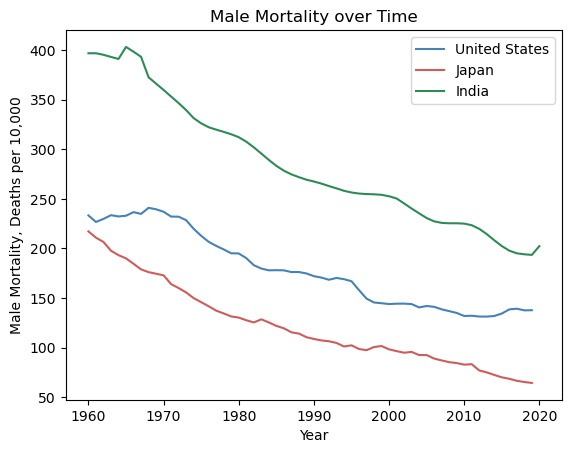

In [17]:
us["Male Mortality"].plot(c="steelblue")
jpn["Male Mortality"].plot(c="indianred")
ind["Male Mortality"].plot(c="seagreen")
plt.legend(('United States', 'Japan', 'India'),
           scatterpoints=1,
           loc='upper right',
           fontsize=10)
plt.xlabel("Year")
plt.title("Male Mortality over Time")
plt.ylabel("Male Mortality, Deaths per 10,000")

Text(0, 0.5, 'Female Mortality, Deaths per 10,000')

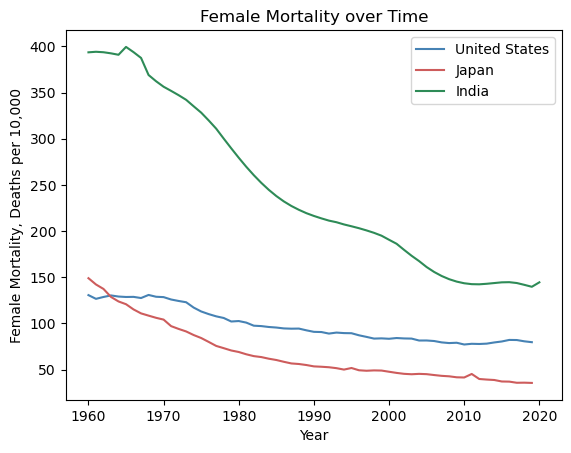

In [18]:
us["Female Mortality"].plot(c="steelblue")
jpn["Female Mortality"].plot(c="indianred")
ind["Female Mortality"].plot(c="seagreen")
plt.legend(('United States', 'Japan', 'India'),
           scatterpoints=1,
           loc='upper right',
           fontsize=10)
plt.title("Female Mortality over Time")
plt.xlabel("Year")
plt.ylabel("Female Mortality, Deaths per 10,000")

Text(0.5, 1.0, 'US, Japan and India Net Migration over Time')

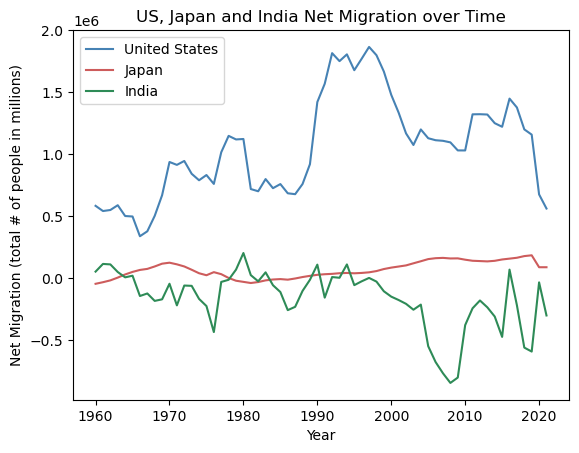

In [19]:
us["Net migration"].plot(c="steelblue")
jpn["Net migration"].plot(c="indianred")
ind["Net migration"].plot(c="seagreen")
plt.legend(('United States', 'Japan', 'India'),
           scatterpoints=1,
           loc='upper left',
           fontsize=10)
plt.xlabel("Year")
plt.ylabel("Net Migration (total # of people in millions)")
plt.title("US, Japan and India Net Migration over Time")

Text(0.5, 1.0, 'US, Japan and India Urban Population (%) over Time')

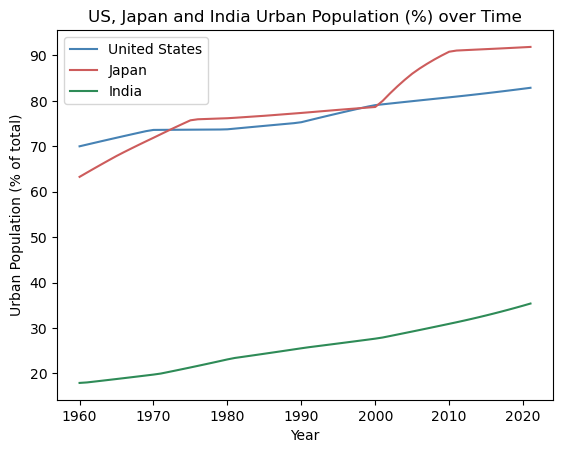

In [20]:
us["Urban Population (% of total)"].plot(c="steelblue")
jpn["Urban Population (% of total)"].plot(c="indianred")
ind["Urban Population (% of total)"].plot(c="seagreen")
plt.legend(('United States', 'Japan', 'India'),
           scatterpoints=1,
           loc='upper left',
           fontsize=10)
plt.xlabel("Year")
plt.ylabel("Urban Population (% of total)")
plt.title("US, Japan and India Urban Population (%) over Time")

Text(0.5, 1.0, 'US, Japan, and India GDP per capita Over Time')

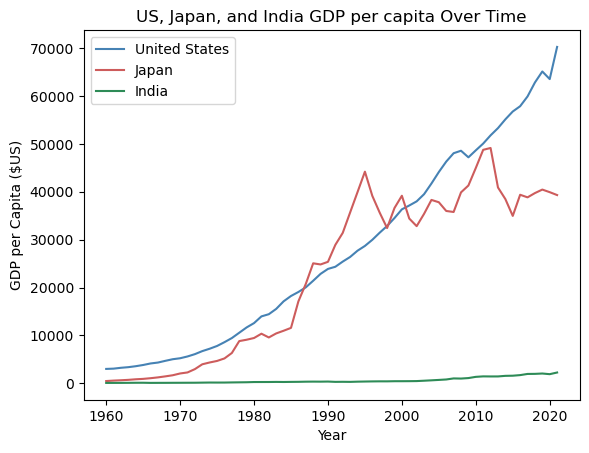

In [21]:
us["GDP per capita"].plot(c="steelblue")
jpn["GDP per capita"].plot(c="indianred")
ind["GDP per capita"].plot(c="seagreen")
plt.legend(('United States', 'Japan', 'India'),
           scatterpoints=1,
           loc='upper left',
           fontsize=10)
plt.xlabel("Year")
plt.ylabel("GDP per Capita ($US)")
plt.title("US, Japan, and India GDP per capita Over Time")

Text(0.5, 1.0, 'US, Japan and India Population Over Time')

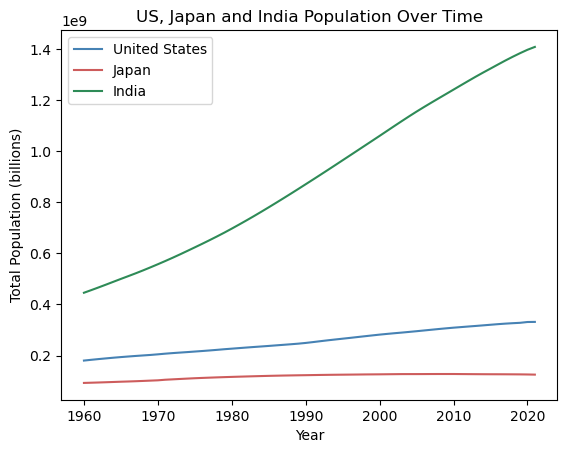

In [22]:
us["Total Population"].plot(c="steelblue")
jpn["Total Population"].plot(c="indianred")
ind["Total Population"].plot(c="seagreen")
plt.legend(('United States', 'Japan', 'India'),
           scatterpoints=1,
           loc='upper left',
           fontsize=10)
plt.xlabel("Year")
plt.ylabel("Total Population (billions)")
plt.title("US, Japan and India Population Over Time")

#### Deliverable #C World Map 

<AxesSubplot:>

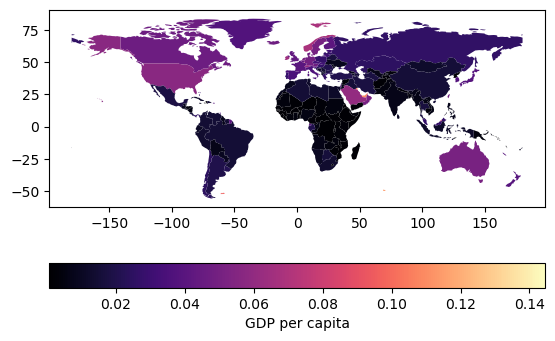

In [23]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
world2 = world.drop(columns=['iso_a3', 'gdp_md_est', 'geometry', 'name'])
population = world2.groupby('continent').sum()
world = world[(world.pop_est>0) & (world.name!="Antarctica")]
world['gdp_per_cap'] = world.gdp_md_est / world.pop_est

fix, ax = plt.subplots(1,1)

world.plot(
    column='gdp_per_cap',
    ax=ax,
    legend=True,
    legend_kwds={'label': "GDP per capita",
                 'orientation': "horizontal"},
    figsize=(30,20),
    cmap='magma')